In [1]:
"https://api.scryfall.com/cards/search?order=set&unique=art&q=set%3A'eld'+lang%3A'en'"

"https://api.scryfall.com/cards/search?order=set&unique=art&q=set%3A'eld'+lang%3A'en'"

In [2]:
# Change dir to get SQL connector
import os
os.chdir("..")
from src.sqldb import SQLDatabase

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import re
import seaborn as sns

# Updating Tables

In [4]:
# Constants
URL = "https://www.mtgtop8.com/format?f=ST"

In [5]:
from src import models as m
def update(URL):
    updater = m.Updater()
    updater.update_events(URL)
    updater.update_decks_and_players()
    updater.update_deck_lists()

In [6]:
update(URL)

Updating next page...


In [7]:
updater = m.Updater()
updater.update_cards()

# Cleaning

Loading data objects...

In [8]:
with SQLDatabase() as sql_db:
    event_table = sql_db.get_dataframe_from("event")
    deck_table = sql_db.get_dataframe_from("deck")
    deck_list_table = sql_db.get_dataframe_from("deckList")
    card_table = sql_db.get_dataframe_from("card")
    pilot_table = sql_db.get_dataframe_from("pilot")

# Clean Dates
event_table["date"] = pd.to_datetime(event_table["date"], dayfirst=True)

# Renaming ID Columns
event_table.rename(columns={"id": "eventId"}, inplace=True)
deck_table.rename(columns={"id": "deckId"}, inplace=True)
pilot_table.rename(columns={"id": "pilotId"}, inplace=True)

# Adding easier ID column to card_table
card_table["setNumber"] = card_table["setNumber"].str.zfill(3)
card_table["cardId"] = card_table["setNumber"] + card_table["setName"]

deck_table.loc[deck_table.deckId==601, "name"] = "GW Adventures"
deck_table.loc[deck_table.deckId==930, "name"] = "Izzet Mill"
deck_table.loc[deck_table.deckId==931, "name"] = "Sultai Ramp"
deck_table.loc[deck_table.deckId==932, "name"] = "Orzhov Aristocrats"
deck_table.loc[deck_table.deckId==934, "name"] = "Temur Control"

Adding archetypes to Deck Table.

These are important to see how play styles are distributed across standard.

Most general archetypes should be on top, so that the more specific archetypes get assigned if applicable.

In [9]:
# Adding archetypes to deck_table
archetypes = {
    "jund": ["jund"],
    "golgari": ["golgari"],
    "aggro": ["aggro", "red deck wins", "weenie", "ww", "mono green", "rdw", "devotion to black", "agro"],
    "control": ["control", "doom", "4cc", "yorion"],
    "midrange": ["midrange", "mid range"],
    "gyruda": ["gyruda"],
    "winota": ["winota"],
    "mill": ["mill"],
    "ramp": ["ramp", "omnath", "ultimatum", "forsaken monument"],
    "rogue": ["rogue"],
    "flash": ["flash"],
    "adventure": ["adventure"],
    "food": ["food"],
    "reclamation": ["reclamation"],
    "sacrifce": ["sacrifice", "aristocrats"],
    "cycling": ["cycling"],
    "kicker": ["kicker", "kick"],
    "mutate": ["mutate"],
    "stompy": ["stompy"]
}

for archetype in archetypes:
    for placeholder in archetypes[archetype]:
        deck_table.loc[
            (deck_table.name.str.lower().str.contains(placeholder)),
            "archetype"
        ] = archetype

deck_table.loc[deck_table.name == "5c Sanctum", "archetype"] = "control"
deck_table.loc[deck_table.deckId == 2452, "archetype"] = "aggro"
deck_table.loc[deck_table.deckId == 2757, "archetype"] = "control"

Adding color categories to Deck Table.

Color category is a big factor when looking at how the makeup of standard has evolved.

In [10]:
# Adding easy color groups to deck_table
categories = {
    "mono white": ["mono white", "mono-white", "white weenie", "weenie white", "ww"],
    "mono blue": ["mono blue", "mono-blue"],
    "mono black": ["mono black", "mono-black", "devotion to black"],
    "mono red": ["mono red", "mono-red", "red deck wins", "rdw"],
    "mono green": ["mono green", "mono-green", "monogreen"],
    "azorius": ["azorius", "uw", "wu"],
    "orzhov": ["orzhov", "wb", "bw"],
    "boros": ["boros", "wr", "rw", "winota"],
    "selesnya": ["selesnya", "wg", "gw"],
    "dimir": ["dimir", "ub"],
    "izzet": ["izzet", "ur"],
    "simic": ["simic", " ug "],
    "rakdos": ["rakdos", "br", "rb"],
    "golgari": ["golgari", "bg", "gb"],
    "gruul": ["gruul", "rg"],
    "bant": ["bant", "gwu", "guw", "ugw", "uwg", "wgu", "wug"],
    "esper": ["esper", "wub"],
    "grixis": ["grixis"],
    "jund": ["jund"],
    "naya": ["naya"],
    "jeskai": ["jeskai"],
    "sultai": ["sultai"],
    "mardu": ["mardu", "kroxa doom"],
    "temur": ["temur"],
    "abzan": ["abzan"],
    "4-color": ["omnath", "4c"],
    "colorless": ["forsaken monument"],
    "5-color": ["5c"]
}

for category in categories:
    for placeholder in categories[category]:
        deck_table.loc[
            (deck_table.name.str.lower().str.contains(placeholder)),
            "category"
        ] = category

deck_table.loc[
    (deck_table.name.str.lower() == "gyruda"),
    "category"
] = "4-color"

deck_table.loc[(deck_table.deckId == 360), "category"] = "gruul"

Some codes are not in Scryfall's api, and some (like the core sets) are not picked up in the source code, which is itself a bug. These codes are manually updated to equivalent cards with recognizable card codes.

In [11]:
# Replace all the abu codes with updated codes for basic lands 
# and Disenchant & Unsummon & Righteousness
abu_codes = {
    "092abu": "266eld",
    "170abu": "262eld",
    "130abu": "254eld",
    "196abu": "250eld",
    "249abu": "258eld",
    "065abu": "010znr",
    "271abu": "078m20",
    "215abu": "027eld"
}

# Adding randomly misformed codes.
other_codes = {
    "171cmd": "204m21", # Scavenging Ooze
    "356eld": "101eld", # Rankle, Master of Pranks
    "367eld": "147eld", # Torbran, Thane of Red Fell
    "335eld": "008eld", # Charming Prince
    "346eld": "054eld", # Midnight Clock
    "001unk": "", # Unknown card
    "003ivg": "174grn", # Goblin Electromancer
    "00410m": "004m10", # Baneslayer Angel
    "00514c": "013m21", # Containment Priest
    "021sha": "021shm", # Runed Halo
    "036str": "126eld", # Fling
    "0496th": "032m20", # Pacifism
    "05110m": "051m10", # Essence Scatter
    "05412m": "054m12", # Frost Breath
    "054m12 ": "054m12",
    "079sta": "103m21", # Grim Tutor
    "083urs": "096m21", # Duress
    "10113m": "101m13", # Murder
    "107dar": "241m21", # Tormod's Crypt
    "1136th": "159m21", # Shock
    "12410m": "124m10", # Act of Treason
    "1276th": "171m21", # Volcanic Geyser
    "144gui": "248rna", # Godless Shrine
    "162gui": "257grn", # Steam Vents
    "163gui": "259rna", # Stomping Ground
    "23215m": "245m15", # Radiant Fountain
    "237urs": "063m21", # Rewind
    "309thb": "076thb", # Thryx, the Sudden Storm
    "328iko": "162iko", # Kogla, the Titan Ape
    "334eld": "001eld", # Acclaimed Contender
    "364znr": "215znr",  # Turntimber Symbiosis // Turntimber, Serpentine...
    "117urs": "021m21",
    "189eld": "187eld",
    "012urs": "042khm"
}

card_table["cardId"].replace(to_replace=abu_codes, inplace=True)
deck_list_table["cardId"].replace(to_replace=abu_codes, inplace=True)

deck_list_table["cardId"].replace(to_replace=other_codes, inplace=True)



New decks need to be checked for misformed codes & missing archetypes/categories

In [12]:
deck_table.loc[deck_table.archetype.isna()]

,deckId,eventId,pilotId,deckUrl,name,rank,archetype,category


In [13]:
deck_table.loc[deck_table.category.isna()]

,deckId,eventId,pilotId,deckUrl,name,rank,archetype,category


In [14]:
unmatched = set(deck_list_table.loc[~(deck_list_table.cardId.isin(card_table.cardId))]["cardId"])

def find_urls_with_unmatched(unmatched):
    unmatched_deck_ids = list(deck_list_table.loc[deck_list_table.cardId == unmatched]["deckId"])
    return set(deck_table.loc[deck_table.deckId.isin(unmatched_deck_ids)]["deckUrl"])

def print_page_source(unmatched):
    unmatched_url = find_urls_with_unmatched(unmatched).pop()
    print(unmatched_url)
    html = requests.get("https://www.mtgtop8.com/event" + unmatched_url)
    return BeautifulSoup(html.text, features="lxml")

In [15]:
find_urls_with_unmatched("012urs")

set()

In [16]:
card_table[card_table["name"] == "Dance of the Manse"]

,setNumber,setName,name,cmc,color,mana_cost,standardLegality,oracle_text,cardId
185,186,eld,Dance of the Manse,2,UW,{X}{W}{U},legal,Return up to X target artifact and/or non-Aura...,186eld
376,377,eld,Dance of the Manse,2,UW,{X}{W}{U},legal,Return up to X target artifact and/or non-Aura...,377eld


In [17]:
deck_list_table[deck_list_table["cardId"] == "012khm"]

,cardId,deckId,count,slot,cardName
74924,012khm,2800,2,md,Glorious Protector
74936,012khm,2800,2,sb,Glorious Protector


In [18]:
unmatched

{''}

In [19]:
ZENDIKAR_RELEASE = "2020-09-25"
KALDHEIM_RELEASE = "2021-02-05"

event_table.loc[event_table["date"] < ZENDIKAR_RELEASE, "latest_set"] = "Ikoria"
event_table.loc[(event_table["date"] >= ZENDIKAR_RELEASE) & (event_table["date"] < KALDHEIM_RELEASE), "latest_set"] = "Zendikar Rising"
event_table.loc[event_table["date"] >= KALDHEIM_RELEASE, "latest_set"] = "Kaldheim"

In [20]:
deck_table[(deck_table["deckUrl"].str.contains("show_pts"))]

,deckId,eventId,pilotId,deckUrl,name,rank,archetype,category
101,102,22,99,?e=27894&d=421299&f=ST&show_pts=Y,Gruul Aggro,11 pts,aggro,gruul
102,103,22,100,?e=27894&d=421300&f=ST&show_pts=Y,Rakdos Aggro,9 pts,aggro,rakdos
103,104,22,101,?e=27894&d=421301&f=ST&show_pts=Y,UB Mill,8 pts,mill,dimir
104,105,22,102,?e=27894&d=421302&f=ST&show_pts=Y,UB Control,8 pts,control,dimir
105,106,22,103,?e=27894&d=421304&f=ST&show_pts=Y,UB Control,8 pts,control,dimir
...,...,...,...,...,...,...,...,...
2155,2156,408,1414,?e=28421&d=424800&f=ST&show_pts=Y,Dimir Control,18 pts,control,dimir
2156,2157,408,600,?e=28421&d=424807&f=ST&show_pts=Y,Dimir Control,18 pts,control,dimir
2157,2158,408,352,?e=28421&d=424810&f=ST&show_pts=Y,Dimir Control,18 pts,control,dimir
2158,2159,408,181,?e=28421&d=424804&f=ST&show_pts=Y,Dimir Rogue,18 pts,rogue,dimir


In [21]:
deck_table.loc[(deck_table["rank"] == "11 pts") & (deck_table["eventId"] == 22), "rank"] = 1
deck_table.loc[(deck_table["rank"] == "9 pts") & (deck_table["eventId"] == 22), "rank"] = 2
deck_table.loc[(deck_table["rank"] == "8 pts") & (deck_table["eventId"] == 22), "rank"] = 3
deck_table.loc[(deck_table["rank"] == "7 pts") & (deck_table["eventId"] == 22), "rank"] = 4
deck_table.loc[(deck_table["rank"] == "6 pts") & (deck_table["eventId"] == 22), "rank"] = 5
deck_table.loc[(deck_table["rank"] == "5 pts") & (deck_table["eventId"] == 22), "rank"] = 6
deck_table.loc[(deck_table["rank"] == "4 pts") & (deck_table["eventId"] == 22), "rank"] = 7

deck_table.loc[(deck_table["rank"] == "9 pts") & (deck_table["eventId"] == 30), "rank"] = 1
deck_table.loc[(deck_table["rank"] == "8 pts") & (deck_table["eventId"] == 30), "rank"] = 2
deck_table.loc[(deck_table["rank"] == "7 pts") & (deck_table["eventId"] == 30), "rank"] = 3
deck_table.loc[(deck_table["rank"] == "6 pts") & (deck_table["eventId"] == 30), "rank"] = 4
deck_table.loc[(deck_table["rank"] == "5 pts") & (deck_table["eventId"] == 30), "rank"] = 5

deck_table.loc[(deck_table["rank"] == "21 pts") & (deck_table["eventId"] == 300), "rank"] = 1
deck_table.loc[(deck_table["rank"] == "1 pts") & (deck_table["eventId"] == 300), "rank"] = 2

deck_table.loc[(deck_table["rank"] == "24 pts") & (deck_table["eventId"] == 408), "rank"] = 1
deck_table.loc[(deck_table["rank"] == "21 pts") & (deck_table["eventId"] == 408), "rank"] = 2
deck_table.loc[(deck_table["rank"] == "18 pts") & (deck_table["eventId"] == 408), "rank"] = 3

In [22]:
deck_table.loc[(deck_table["rank"] == "5-8"), "rank"] = 5

In [23]:
deck_table.loc[(deck_table["rank"] == "3-4"), "rank"] = 3

In [24]:
current_standard = "eld|m21|thb|znr|iko|khm"
current_card_table = card_table[card_table["setName"].str.contains(current_standard, regex=True)]

In [25]:
current_card_table

,setNumber,setName,name,cmc,color,mana_cost,standardLegality,oracle_text,cardId
0,001,eld,Acclaimed Contender,3,W,{2}{W},legal,When Acclaimed Contender enters the battlefiel...,001eld
1,002,eld,All That Glitters,2,W,{1}{W},legal,Enchant creature\nEnchanted creature gets +1/+...,002eld
2,003,eld,Archon of Absolution,4,W,{3}{W},legal,Flying\nProtection from white (This creature c...,003eld
3,004,eld,Ardenvale Paladin,4,W,{3}{W},legal,Adamant — If at least three white mana was spe...,004eld
4,005,eld,Ardenvale Tactician // Dizzying Swoop,3,W,{1}{W}{W} // {1}{W},legal,Flying // Tap up to two target creatures. (The...,005eld
...,...,...,...,...,...,...,...,...,...
14100,401,khm,Usher of the Fallen,1,W,{W},legal,Boast — {1}{W}: Create a 1/1 white Human Warri...,401khm
14101,402,khm,Strategic Planning,2,U,{1}{U},legal,Look at the top three cards of your library. P...,402khm
14102,403,khm,Poison the Cup,3,B,{1}{B}{B},legal,Destroy target creature. If this spell was for...,403khm
14103,404,khm,Frost Bite,1,R,{R},legal,Frost Bite deals 2 damage to target creature o...,404khm


In [26]:
events_and_decks = pd.merge(
    event_table, 
    deck_table, 
    on="eventId",
    suffixes=["_event", "_deck"]
).drop_duplicates()

events_decks_pilots = pd.merge(
    events_and_decks,
    pilot_table,
    on="pilotId",
    suffixes=[None, "_pilot"]
).drop_duplicates()

full_table_no_cards = pd.merge(
    events_decks_pilots,
    deck_list_table,
    on="deckId",
    suffixes=[None, "_decklist"]
).drop_duplicates()

full_table1 = pd.merge(
    full_table_no_cards,
    card_table,
    on="cardId",
    suffixes=[None, "_cards"]
)[[
    "eventId",
    "name_event",
    "date",
    "deckId",
    "pilotId",
    "name_deck",
    "firstName",
    "lastName",
    "cardId",
    "name",
    "count",
    "color",
    "slot",
    "archetype",
    "category",
    "latest_set"
]].drop_duplicates().sort_values(by=["eventId", "deckId", "slot"]).reset_index(drop=True)

In [27]:
pd.isnull(full_table1["cardId"]).any()

False

In [28]:
pd.isnull(full_table1["cardId"]).any()

False

In [63]:
standard_sets = "eld|thb|znr|iko|khm|m21"
full_table1[
    (~full_table1["cardId"].str.contains(standard_sets, regex=True))
    & (full_table1["date"] >= "2020-09-04")
][["cardId", "name"]].drop_duplicates()

,cardId,name
9598,077grn,Midnight Reaper
14906,109m20,Murder
18269,081rna,Pestilent Spirit
24392,246rna,Breeding Pool
24393,042m20,Aether Gust
...,...,...
29910,037rna,Essence Capture
29940,225war,Tyrant's Scorn
30086,174grn,Goblin Electromancer
30229,036dka,Dungeon Geists


In [57]:
deck_table[
    deck_table["deckId"].isin(
        full_table1[
            full_table1["cardId"] == "309ice"
        ]
        ["deckId"]
    )
]

,deckId,eventId,pilotId,deckUrl,name,rank,archetype,category
2787,2788,535,1703,?e=29029&d=428737&f=ST,Mono White Control,1,control,mono white
2794,2795,535,1707,?e=29029&d=428741&f=ST,WW,5,aggro,mono white


In [64]:
card_table[card_table["name"] == "Pestilent Spirit"]

,setNumber,setName,name,cmc,color,mana_cost,standardLegality,oracle_text,cardId
2282,081,rna,Pestilent Spirit,3,B,{2}{B},not_legal,"Menace, deathtouch\nInstant and sorcery spells...",081rna


In [41]:
def update_set_codes(old, new, name=None, color=None):
    if name:
        full_table1.loc[full_table1["cardId"] == old, "name"] = name
    if color:
        full_table1.loc[full_table1["cardId"] == old, "color"] = color
    full_table1.loc[full_table1["cardId"] == old, "cardId"] = new
    deck_list_table.loc[deck_list_table["cardId"] == old, "cardId"] = new


In [59]:
update_set_codes("228ths", "256m21")
update_set_codes("043mor", "071znr")
update_set_codes("001frf", "001m21")
update_set_codes("119akh", "107iko")
update_set_codes("228roe", "247iko")
update_set_codes("201isd", "199m21")
update_set_codes("245mrd", "239m21")
update_set_codes("096isd", "083iko")
update_set_codes("005jou", "004thb")
update_set_codes("148rix", "209m21")
update_set_codes("225ths", "245thb")
update_set_codes("051m10", "049iko")
update_set_codes("246ktk", "257iko")
update_set_codes("165jou", "253m21")
update_set_codes("160bng", "246thb", "Temple of Enlightenment", "")
update_set_codes("161bng", "247thb", "Temple of Malice", "")
update_set_codes("088ths", "099thb", "Gray Merchant of Asphodel", "B")
update_set_codes("162bng", "248thb", "Temple of Plenty", "")
update_set_codes("175war", "197thb")
update_set_codes("169inv", "059m21", "Opt", "U")
update_set_codes("232ktk", "246iko")
update_set_codes("235ktk", "249iko")
update_set_codes("065mh1", "061m21")
update_set_codes("048zen", "062znr")
update_set_codes("227ths", "255m21")
update_set_codes("168zen", "193znr")
update_set_codes("065som", "102m21")
update_set_codes("168m11", "177m21")
update_set_codes("109aer", "188m21")
update_set_codes("115ori", "103eld")
update_set_codes("004m10", "006m21")
update_set_codes("226ths", "254m21")
update_set_codes("248xln", "233eld")
update_set_codes("164jou", "252m21")
update_set_codes("143isd", "145m21")
update_set_codes("043hou", "064m21")
update_set_codes("224ths", "244thb")
update_set_codes("088hou", "140m21")
update_set_codes("018som", "034thb")
update_set_codes("145m20", "141thb")
update_set_codes("190m11", "169iko")
update_set_codes("229ktk", "243iko")
update_set_codes("240ktk", "252iko")
update_set_codes("176war", "207m21")
update_set_codes("110xln", "107m21")
update_set_codes("046mbs", "114m21")
update_set_codes("201chk", "173m21")
update_set_codes("236ktk", "255iko", "Swiftwater Cliffs", "")
update_set_codes("237ktk", "256iko", "Thornwood Falls", "")
update_set_codes("255xln", "242thb", "Field of Ruin", "")
update_set_codes("232m15", "248m21", "Radiant Fountain", "")
update_set_codes("229ths", "249thb")
update_set_codes("190som", "234m21")
update_set_codes("010war", "009iko")
update_set_codes("079emn", "082m21")
update_set_codes("010ktk", "019m21")
update_set_codes("040ori", "043m21")
update_set_codes("223soi", "199znr")
update_set_codes("082mbs", "163iko")
update_set_codes("247ktk", "258iko")
update_set_codes("147roe", "147m21")
update_set_codes("078aer", "141m21")
update_set_codes("032m20", "025iko")
update_set_codes("016rav", "017m21")
update_set_codes("231ktk", "244iko")
update_set_codes("035m19", "031m21")
update_set_codes("145war", "161m21")
update_set_codes("041rav", "045iko")
update_set_codes("133ths", "149thb")
update_set_codes("168akh", "157iko")
update_set_codes("054m12", "051m21")
update_set_codes("245m19", "238m21")
update_set_codes("242ktk", "254iko")
update_set_codes("279leg", "121thb", "Underworld Dreams", "B")
update_set_codes("011dom", "016m21", "Dub", "W")
update_set_codes("310ice", "382znr", "Swamp", "")
update_set_codes("189dom", "142iko", "Adventurous Impulse", "G")
update_set_codes("076dom", "082iko", "Dark Bargain", "B")
update_set_codes("101m13", "109m20")
update_set_codes("172dis", "246rna")
update_set_codes("051tsp", "046m21")
update_set_codes("149dka", "227m20")
update_set_codes("021shm", "032m21")
update_set_codes("034isd", "042znr", "Smite the Monstrous","W")
update_set_codes("108kld", "110iko", "Cathartic Reunion", "R")
update_set_codes("090dom", "094m21", "Deathbloom Thallid", "B")
update_set_codes("037ktk", "054khm")
update_set_codes("307ice", "278khm", "Snow-Covered Island")
update_set_codes("308ice", "283khm", "Snow-Covered Mountain")
update_set_codes("306ice", "284khm", "Snow-Covered Forest")
update_set_codes("309ice", "277khm", "Snow-Covered Plains")

In [61]:
full_table1[full_table1["name"] == "Glorious Protector"]

,eventId,name_event,date,deckId,pilotId,name_deck,firstName,lastName,cardId,name,count,color,slot,archetype,category,latest_set
74933,537,"Coupe de France FFJV, Qualifier #1 @ Fédératio...",2021-01-30,2800,1711,Weenie White,Franck,Goubier,012khm,Glorious Protector,2,W,md,aggro,mono white,Zendikar Rising
74938,537,"Coupe de France FFJV, Qualifier #1 @ Fédératio...",2021-01-30,2800,1711,Weenie White,Franck,Goubier,012khm,Glorious Protector,2,W,sb,aggro,mono white,Zendikar Rising


In [62]:
full_table1.to_csv("flat_files/full_table.csv", index=False)
event_table.to_csv("flat_files/event_table.csv", index=False)
deck_table.to_csv("flat_files/deck_table.csv", index=False)
deck_list_table.to_csv("flat_files/deck_list_table.csv", index=False)
card_table.to_csv("flat_files/card_table.csv", index=False)
pilot_table.to_csv("flat_files/pilot_table.csv", index=False)

In [19]:
full_table = full_table1[~full_table1["name"].isin(["Island", "Plains", "Mountain", "Swamp", "Forest"])].copy()

In [20]:
deck_table.head(25)

,deckId,eventId,pilotId,deckUrl,name,rank,archetype,category
0,1,1,3,?e=27938&d=421597&f=ST,Gruul Aggro,1,aggro,gruul
1,2,1,4,?e=27938&d=421598&f=ST,UW Control,2,control,azorius
2,3,2,5,?e=27939&d=421599&f=ST,Red Deck Wins,1,aggro,mono red
3,4,3,6,?e=27940&d=421600&f=ST,Rakdos Aggro,1,aggro,rakdos
4,5,4,7,?e=27925&d=421512&f=ST,Gruul Aggro,1,aggro,gruul
5,6,4,8,?e=27925&d=421513&f=ST,Gruul Aggro,2,aggro,gruul
6,7,4,9,?e=27925&d=421515&f=ST,Gruul Aggro,3-4,aggro,gruul
7,8,4,10,?e=27925&d=421514&f=ST,Rakdos Aggro,3-4,aggro,rakdos
8,9,4,11,?e=27925&d=421517&f=ST,Boros Cycling Aggro,5-8,cycling,boros
9,10,4,12,?e=27925&d=421518&f=ST,Gruul Aggro,5-8,aggro,gruul


In [21]:
full_table.head(25)

,eventId,name_event,date,deckId,pilotId,name_deck,firstName,lastName,cardId,name,count,color,slot,archetype,category
0,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,261znr,Cragcrown Pathway // Timbercrown Pathway,4,GR,md,aggro,gruul
1,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,244eld,Fabled Passage,4,,md,aggro,gruul
4,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,115eld,Bonecrusher Giant // Stomp,4,R,md,aggro,gruul
5,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,221znr,Brushfire Elemental,4,GR,md,aggro,gruul
6,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,151eld,Edgewall Innkeeper,4,G,md,aggro,gruul
7,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,189znr,Kazandu Mammoth // Kazandu Valley,4,G,md,aggro,gruul
8,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,299eld,Lovestruck Beast // Heart's Desire,4,G,md,aggro,gruul
9,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,171eld,Questing Beast,2,G,md,aggro,gruul
10,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,137eld,Rimrock Knight // Boulder Rush,2,R,md,aggro,gruul
11,1,FNM @ MTG Arena Campania,2020-10-30,1,3,Gruul Aggro,Antimo,Morlando,204m21,Scavenging Ooze,3,G,md,aggro,gruul


In [22]:
full_table.drop_duplicates("deckId").groupby("archetype")["deckId"].count().sort_values(ascending=False).reset_index()

,archetype,deckId
0,aggro,1276
1,control,659
2,ramp,335
3,mill,195
4,adventure,110
5,rogue,87
6,cycling,35
7,jund,26
8,winota,16
9,food,11


In [23]:
full_table.loc[
    full_table["date"] >= "2020-09-25"
].drop_duplicates("deckId").groupby(["archetype"])["deckId"].count().sort_values(ascending=False).reset_index()

,archetype,deckId
0,aggro,1169
1,control,560
2,ramp,263
3,mill,193
4,rogue,87
5,adventure,81
6,cycling,33
7,jund,25
8,food,11
9,winota,10


In [24]:
full_table.loc[
    full_table["date"] < "2020-09-28"
].drop_duplicates(["deckId"]).groupby("archetype")["deckId"].count().sort_values(ascending=False).reset_index()

,archetype,deckId
0,ramp,127
1,aggro,126
2,control,124
3,adventure,46
4,winota,6
5,cycling,4
6,flash,2
7,mill,2
8,reclamation,2
9,golgari,1


In [25]:
full_table.drop_duplicates("deckId").groupby("category")["deckId"].count().sort_values(ascending=False).reset_index()

,category,deckId
0,gruul,574
1,dimir,387
2,mono green,255
3,4-color,204
4,esper,172
5,rakdos,161
6,mono red,159
7,temur,156
8,sultai,113
9,simic,97


In [26]:
full_table.loc[
    full_table["date"] >= "2020-09-28"
].drop_duplicates(["deckId"]).groupby("category")["deckId"].count().sort_values(ascending=False).reset_index()

,category,deckId
0,gruul,550
1,dimir,373
2,mono green,216
3,esper,169
4,rakdos,146
5,temur,136
6,mono red,126
7,simic,93
8,4-color,75
9,boros,58


In [27]:
full_table.loc[
    full_table["date"] < "2020-09-28"
].drop_duplicates(["deckId"]).groupby("category")["deckId"].count().sort_values(ascending=False).reset_index()

,category,deckId
0,4-color,129
1,sultai,95
2,izzet,40
3,mono green,39
4,mono red,33
5,gruul,24
6,temur,20
7,rakdos,15
8,dimir,14
9,boros,10


In [28]:
full_table.loc[
    full_table["archetype"] == "flash"
]["deckId"].value_counts()

1101    30
1038    27
21      24
Name: deckId, dtype: int64

In [29]:
full_table.isna().any()

eventId       False
name_event    False
date          False
deckId        False
pilotId       False
name_deck     False
firstName     False
lastName      False
cardId        False
name          False
count         False
color         False
slot          False
archetype     False
category      False
dtype: bool

In [30]:
full_table.loc[
    full_table.category.isna()
][["deckId", "name_deck", "category"]]

,deckId,name_deck,category


In [31]:
total_counts = full_table.loc[
    ~(full_table.name.isin(["Forest", "Swamp", "Mountain", "Island", "Plains"]))
].groupby("name")["count"].sum().sort_values(ascending=False).reset_index().head(25)

total_counts["pct_of_total"] = total_counts["count"].div(total_counts["count"].sum())

In [32]:
total_counts

,name,count,pct_of_total
0,Fabled Passage,7416,0.106937
1,Bonecrusher Giant // Stomp,4871,0.070239
2,Lovestruck Beast // Heart's Desire,4047,0.058357
3,Cragcrown Pathway // Timbercrown Pathway,3593,0.051810
4,Mystical Dispute,3551,0.051205
5,Kazandu Mammoth // Kazandu Valley,3494,0.050383
6,"Shatterskull Smashing // Shatterskull, the Ham...",3166,0.045653
7,Edgewall Innkeeper,3090,0.044557
8,Scavenging Ooze,2737,0.039467
9,Heartless Act,2622,0.037809


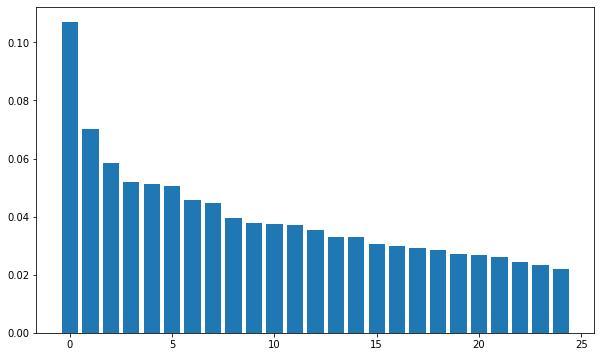

In [33]:
plt.close("all")
plt.figure(figsize=(10, 6))
plt.bar(range(len(total_counts["name"])), total_counts["pct_of_total"])
plt.show()

In [34]:
full_table["deckId"].nunique()

2774

In [35]:
standard_df = full_table[
    ~full_table["name"].isin(["Forest", "Mountain", "Island", "Swamp", "Plains"])
    & (full_table["slot"] == "md")
]

decks_per_card = standard_df.groupby(["name"])["deckId"].nunique().reset_index().sort_values(by="deckId", ascending=False)
decks_per_card["pct"] = decks_per_card["deckId"].div(standard_df["deckId"].nunique())

In [36]:
decks_per_card

,name,deckId,pct
205,Fabled Passage,1972,0.710887
68,Bonecrusher Giant // Stomp,1208,0.435472
388,Lovestruck Beast // Heart's Desire,1007,0.363014
601,"Shatterskull Smashing // Shatterskull, the Ham...",994,0.358327
121,Cragcrown Pathway // Timbercrown Pathway,957,0.344989
...,...,...,...
102,Chemister's Insight,1,0.000360
193,"Erebos, Bleak-Hearted",1,0.000360
98,"Chandra, Acolyte of Flame",1,0.000360
442,Mythos of Brokkos,1,0.000360


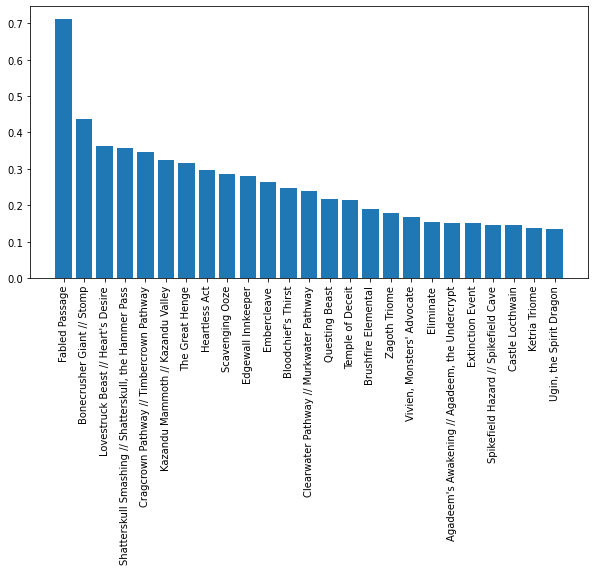

In [37]:
plt.close("all")
plt.figure(figsize=(10, 5))
ax = plt.subplot()

pcts = decks_per_card["pct"].head(25)
cards = decks_per_card["name"].head(25)
plt.bar(range(len(pcts)), pcts)
ax.set_xticks(range(len(pcts)))
ax.set_xticklabels(cards, rotation=90)
plt.show()

In [38]:
standard_df["name"].value_counts(normalize=True)

Fabled Passage                                            0.041673
Bonecrusher Giant // Stomp                                0.025528
Lovestruck Beast // Heart's Desire                        0.021280
Shatterskull Smashing // Shatterskull, the Hammer Pass    0.021005
Cragcrown Pathway // Timbercrown Pathway                  0.020224
                                                            ...   
Kitesail Cleric                                           0.000021
Verazol, the Split Current                                0.000021
Simic Keyrune                                             0.000021
Greater Sandwurm                                          0.000021
Rambunctious Mutt                                         0.000021
Name: name, Length: 793, dtype: float64

In [39]:
full_table.drop_duplicates(subset=["eventId", "deckId"]).groupby(["name_deck"]).eventId.count().sort_values(ascending=False).reset_index().head(30)

,name_deck,eventId
0,Gruul Aggro,507
1,Mono Green Aggro,243
2,Omnath Ramp,182
3,Dimir Mill,166
4,Esper DOOM Yorion,152
5,Red Deck Wins,144
6,Rakdos Aggro,129
7,Sultai Control,103
8,Dimir Control,103
9,Dimir Rogue,84


### QUESTION 1: 

How has color dominance changed over time?

In [40]:
green_categories = [
    "mono green",
    "gruul",
    "selesnya",
    "golgari",
    "temur",
    "sultai",
    "abzan"
]

In [41]:
full_table_cols = full_table.columns.tolist()
event_table_cols = event_table.columns.tolist()
deck_table_cols = deck_table.columns.tolist()

In [42]:
event_dates = full_table.date

In [43]:
green_cards = full_table[full_table.color.str.contains("G")].groupby("date")["count"].sum().reset_index()
blue_cards = full_table[full_table.color.str.contains("U")].groupby("date")["count"].sum().reset_index()
black_cards = full_table[full_table.color.str.contains("B")].groupby("date")["count"].sum().reset_index()
white_cards = full_table[full_table.color.str.contains("W")].groupby("date")["count"].sum().reset_index()
red_cards = full_table[full_table.color.str.contains("R")].groupby("date")["count"].sum().reset_index()
all_cards = full_table.groupby("date")["count"].sum().reset_index()

In [44]:
green_cards

,date,count
0,2020-09-03,144
1,2020-09-04,303
2,2020-09-05,145
3,2020-09-06,789
4,2020-09-07,487
...,...,...
128,2021-01-22,181
129,2021-01-23,342
130,2021-01-24,252
131,2021-01-26,293


In [45]:
white_cards

,date,count
0,2020-09-04,74
1,2020-09-05,1
2,2020-09-06,8
3,2020-09-07,148
4,2020-09-08,45
...,...,...
120,2021-01-23,104
121,2021-01-24,106
122,2021-01-25,26
123,2021-01-26,132


In [46]:
black_cards

,date,count
0,2020-09-03,31
1,2020-09-04,234
2,2020-09-05,179
3,2020-09-06,434
4,2020-09-07,259
...,...,...
131,2021-01-23,368
132,2021-01-24,254
133,2021-01-25,28
134,2021-01-26,268


In [47]:
all_cards

,date,count
0,2020-09-03,244
1,2020-09-04,897
2,2020-09-05,445
3,2020-09-06,1742
4,2020-09-07,1323
...,...,...
134,2021-01-23,1325
135,2021-01-24,942
136,2021-01-25,107
137,2021-01-26,1194


In [48]:
colors_by_date = (
    green_cards.merge(black_cards, suffixes=["_green", "_black"], on="date", how="outer")
    .merge(white_cards, on="date", suffixes=[None, "_white"], how="outer")
    .merge(blue_cards, on="date", suffixes=[None, "_blue"], how="outer")
    .merge(red_cards, on="date", suffixes=[None, "_red"], how="outer")
    .merge(all_cards, on="date", suffixes=[None, "_all"], how="outer")
)
colors_by_date.columns = ["date", "green", "black", "white", "blue", "red", "all"]

In [49]:
colors_by_date.sort_values(by="date", ascending=True, inplace=True)

In [50]:
colors_by_date

,date,green,black,white,blue,red,all
0,2020-09-03,144.0,31.0,NaN,79.0,34.0,244
1,2020-09-04,303.0,234.0,74.0,335.0,143.0,897
2,2020-09-05,145.0,179.0,1.0,202.0,43.0,445
3,2020-09-06,789.0,434.0,8.0,759.0,306.0,1742
4,2020-09-07,487.0,259.0,148.0,381.0,319.0,1323
...,...,...,...,...,...,...,...
129,2021-01-23,342.0,368.0,104.0,228.0,400.0,1325
130,2021-01-24,252.0,254.0,106.0,234.0,181.0,942
137,2021-01-25,NaN,28.0,26.0,NaN,59.0,107
131,2021-01-26,293.0,268.0,132.0,247.0,290.0,1194


In [51]:
colors_by_date.set_index("date", inplace=True)

In [52]:
import matplotlib.pyplot as plt

In [53]:
def plot_colors(df):
    pass

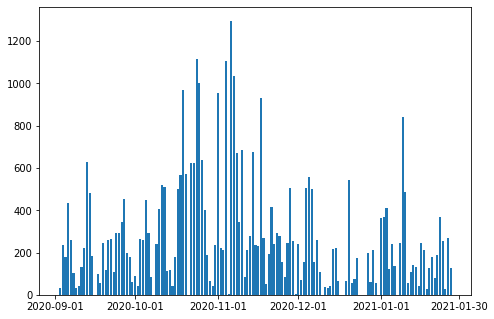

In [54]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
dates = list(map(pd.Timestamp.date, colors_by_date.index))

ax.bar(dates, colors_by_date.black)
ax.set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-01-30"])

plt.show()

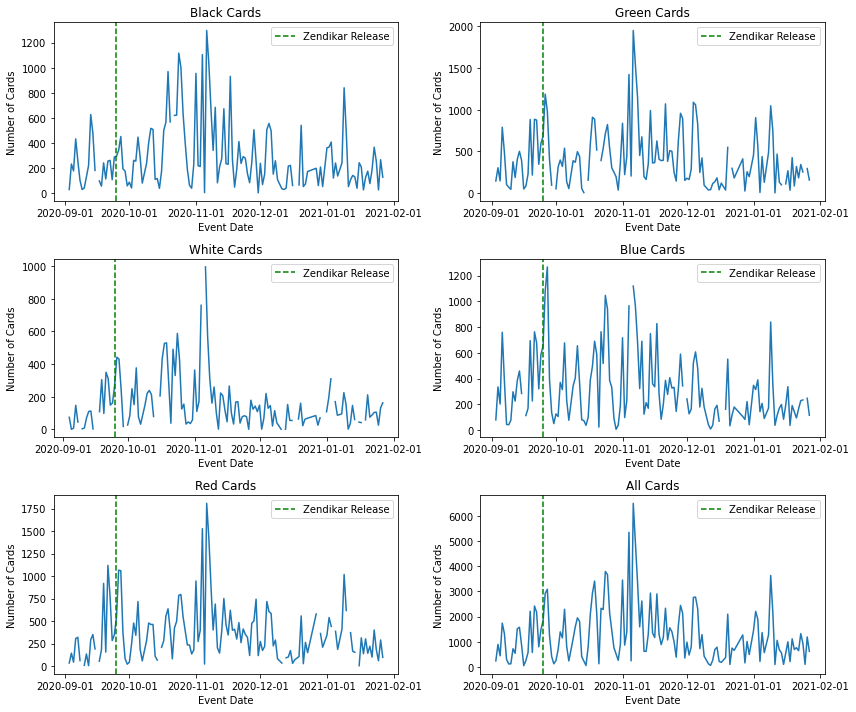

In [55]:
plt.close("all")
fig, a = plt.subplots(3, 2)
dates = list(map(pd.Timestamp.date, colors_by_date.index))

a[0][0].plot(dates, colors_by_date.black)
a[0][0].set_title("Black Cards")
a[0][0].set_xlabel("Event Date")
a[0][0].set_ylabel("Number of Cards")
a[0][0].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])
a[0][0].axvline("2020-09-25", label="Zendikar Release", ls="--", c="green")
a[0][0].legend()

a[0][1].plot(dates, colors_by_date.green)
a[0][1].set_title("Green Cards")
a[0][1].set_xlabel("Event Date")
a[0][1].set_ylabel("Number of Cards")
a[0][1].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])
a[0][1].axvline("2020-09-25", label="Zendikar Release", ls="--", c="green")
a[0][1].legend()

a[1][0].plot(dates, colors_by_date.white)
a[1][0].set_title("White Cards")
a[1][0].set_xlabel("Event Date")
a[1][0].set_ylabel("Number of Cards")
a[1][0].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])
a[1][0].axvline("2020-09-25", label="Zendikar Release", ls="--", c="green")
a[1][0].legend()

a[1][1].plot(dates, colors_by_date.blue)
a[1][1].set_title("Blue Cards")
a[1][1].set_xlabel("Event Date")
a[1][1].set_ylabel("Number of Cards")
a[1][1].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])
a[1][1].axvline("2020-09-25", label="Zendikar Release", ls="--", c="green")
a[1][1].legend()

a[2][0].plot(dates, colors_by_date.red)
a[2][0].set_title("Red Cards")
a[2][0].set_xlabel("Event Date")
a[2][0].set_ylabel("Number of Cards")
a[2][0].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])
a[2][0].axvline("2020-09-25", label="Zendikar Release", ls="--", c="green")
a[2][0].legend()

a[2][1].plot(dates, colors_by_date["all"])
a[2][1].set_title("All Cards")
a[2][1].set_xlabel("Event Date")
a[2][1].set_ylabel("Number of Cards")
a[2][1].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])
a[2][1].axvline("2020-09-25", label="Zendikar Release", ls="--", c="green")
a[2][1].legend()

fig.set_figwidth(12)
fig.set_figheight(10)

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='date'>

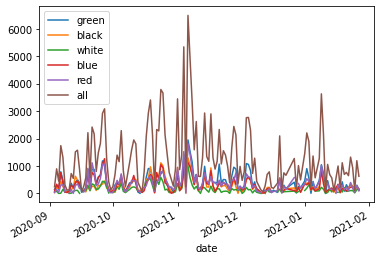

In [56]:
colors_by_date.plot()

In [57]:
full_table[(full_table.date < "2020-11-01") & (full_table.date >= "2020-10-20")].eventId.nunique()

55

In [58]:
control_decks = full_table[full_table.archetype=="control"].drop_duplicates(subset="deckId").groupby("date")["deckId"].count().reset_index().rename(columns={"deckId": "control"})
aggro_decks = full_table[full_table.archetype=="aggro"].drop_duplicates(subset="deckId").groupby("date")["deckId"].count().reset_index().rename(columns={"deckId": "aggro"})
ramp_decks = full_table[full_table.archetype=="ramp"].drop_duplicates(subset="deckId").groupby("date")["deckId"].count().reset_index().rename(columns={"deckId": "ramp"})
mill_decks = full_table[full_table.archetype=="mill"].drop_duplicates(subset="deckId").groupby("date")["deckId"].count().reset_index().rename(columns={"deckId": "mill"})
adventure_decks = full_table[full_table.archetype=="adventure"].drop_duplicates(subset="deckId").groupby("date")["deckId"].count().reset_index().rename(columns={"deckId": "adventure"})
rogues_decks = full_table[full_table.archetype=="rogue"].drop_duplicates(subset="deckId").groupby("date")["deckId"].count().reset_index().rename(columns={"deckId": "rogue"})

In [59]:
archetypes_by_date = (
    control_decks.merge(aggro_decks, how="outer", on="date")
    .merge(ramp_decks, how="outer", on="date")
    .merge(mill_decks, how="outer", on="date")
    .merge(adventure_decks, how="outer", on="date")
    .merge(rogues_decks, how="outer", on="date")
).sort_values(by="date").fillna(0)

In [60]:
archetypes_by_date

,date,control,aggro,ramp,mill,adventure,rogue
0,2020-09-03,2.0,2.0,0.0,0.0,0.0,0.0
1,2020-09-04,7.0,5.0,0.0,0.0,1.0,0.0
2,2020-09-05,3.0,3.0,0.0,0.0,0.0,0.0
3,2020-09-06,18.0,7.0,0.0,0.0,1.0,0.0
4,2020-09-07,7.0,9.0,0.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...
118,2021-01-23,4.0,13.0,1.0,2.0,0.0,0.0
119,2021-01-24,3.0,7.0,1.0,3.0,0.0,0.0
136,2021-01-25,0.0,2.0,0.0,0.0,0.0,0.0
120,2021-01-26,7.0,6.0,1.0,2.0,1.0,0.0


In [61]:
for archetype in ["control", "aggro", "ramp", "mill", "adventure", "rogue"]:
    archetypes_by_date[archetype] = archetypes_by_date[archetype].astype(int)

In [62]:
archetypes_by_date

,date,control,aggro,ramp,mill,adventure,rogue
0,2020-09-03,2,2,0,0,0,0
1,2020-09-04,7,5,0,0,1,0
2,2020-09-05,3,3,0,0,0,0
3,2020-09-06,18,7,0,0,1,0
4,2020-09-07,7,9,0,0,3,0
...,...,...,...,...,...,...,...
118,2021-01-23,4,13,1,2,0,0
119,2021-01-24,3,7,1,3,0,0
136,2021-01-25,0,2,0,0,0,0
120,2021-01-26,7,6,1,2,1,0


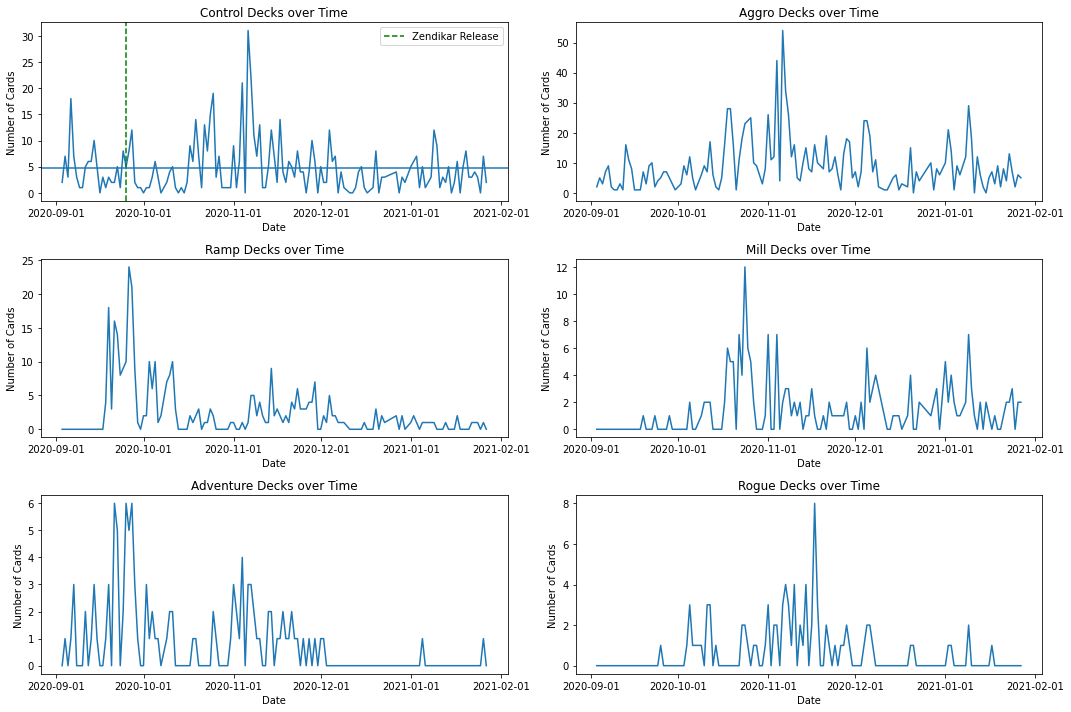

In [63]:
fig, ax = plt.subplots(3, 2)
dates = list(map(pd.Timestamp.date, archetypes_by_date["date"]))

ax[0][0].plot(dates, archetypes_by_date.control)
ax[0][0].set_title("Control Decks over Time")
ax[0][0].set_xlabel("Date")
ax[0][0].set_ylabel("Number of Cards")
ax[0][0].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])

ax[0][1].plot(dates, archetypes_by_date.aggro)
ax[0][1].set_title("Aggro Decks over Time")
ax[0][1].set_xlabel("Date")
ax[0][1].set_ylabel("Number of Cards")
ax[0][1].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])

ax[1][0].plot(dates, archetypes_by_date.ramp)
ax[1][0].set_title("Ramp Decks over Time")
ax[1][0].set_xlabel("Date")
ax[1][0].set_ylabel("Number of Cards")
ax[1][0].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])

ax[1][1].plot(dates, archetypes_by_date.mill)
ax[1][1].set_title("Mill Decks over Time")
ax[1][1].set_xlabel("Date")
ax[1][1].set_ylabel("Number of Cards")
ax[1][1].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])

ax[2][0].plot(dates, archetypes_by_date.adventure)
ax[2][0].set_title("Adventure Decks over Time")
ax[2][0].set_xlabel("Date")
ax[2][0].set_ylabel("Number of Cards")
ax[2][0].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])

ax[2][1].plot(dates, archetypes_by_date.rogue)
ax[2][1].set_title("Rogue Decks over Time")
ax[2][1].set_xlabel("Date")
ax[2][1].set_ylabel("Number of Cards")
ax[2][1].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])

ax[0][0].axvline("2020-09-25", label="Zendikar Release", ls="--", c="green")
ax[0][0].axhline(np.mean(archetypes_by_date.control))
ax[0][0].legend()
fig.set_figwidth(15)
fig.set_figheight(10)

plt.tight_layout()
plt.show()

In [64]:
standard = ["eld", "m21", "iko", "thb", "znr"]

In [65]:
card_table.setName.unique()

array(['eld', 'thb', 'iko', 'm21', 'znr', 'war', 'rna', 'grn', 'm20',
       'mor', 'frf', 'm11', 'm12', 'm10', 'm13', 'm19', 'm14', 'm15',
       'aer', 'akh', 'bng', 'chk', 'dom', 'dis', 'dka', 'emn', 'gtc',
       'hou', 'ice', 'inv', 'isd', 'jou', 'ktk', 'leg', 'mbs', 'mh1',
       'mrd', 'ogw', 'ori', 'rav', 'rix', 'roe', 'rtr', 'shm', 'soi',
       'som', 'ths', 'tsp', 'xln', 'zen', 'kld'], dtype=object)

In [66]:
eld = full_table[full_table.cardId.str.endswith("eld")].groupby("date")["count"].sum().reset_index().rename(columns={"count": "eld"})
m21 = full_table[full_table.cardId.str.endswith("m21")].groupby("date")["count"].sum().reset_index().rename(columns={"count": "m21"})
iko = full_table[full_table.cardId.str.endswith("iko")].groupby("date")["count"].sum().reset_index().rename(columns={"count": "iko"})
thb = full_table[full_table.cardId.str.endswith("thb")].groupby("date")["count"].sum().reset_index().rename(columns={"count": "thb"})
znr = full_table[full_table.cardId.str.endswith("znr")].groupby("date")["count"].sum().reset_index().rename(columns={"count": "znr"})

In [67]:
thb

,date,thb
0,2020-09-03,11
1,2020-09-04,74
2,2020-09-05,35
3,2020-09-06,130
4,2020-09-07,98
...,...,...
133,2021-01-23,196
134,2021-01-24,132
135,2021-01-25,16
136,2021-01-26,174


In [68]:
sets_by_date = (
    eld.merge(m21, on="date", how="outer")
    .merge(iko, on="date", how="outer")
    .merge(thb, on="date", how="outer")
    .merge(znr, on="date", how="outer")
)

In [69]:
sets_by_date_linegraph = sets_by_date.set_index("date")

<AxesSubplot:xlabel='date'>

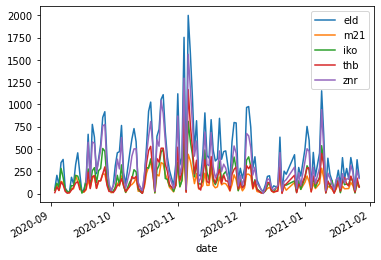

In [70]:
sets_by_date_linegraph.plot()

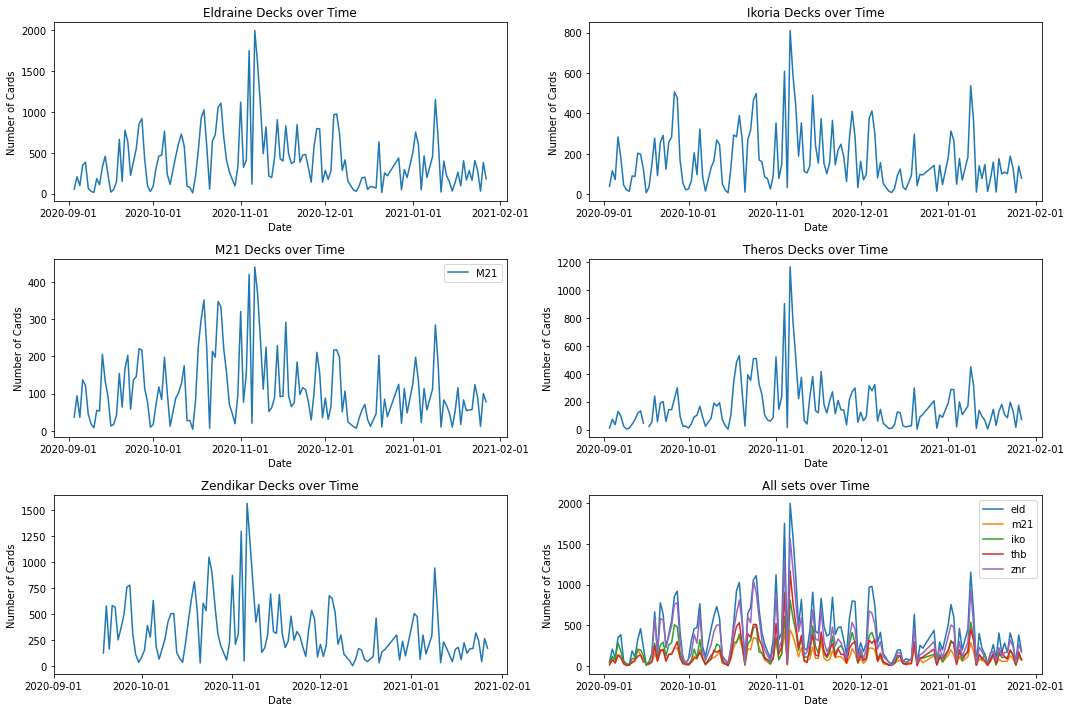

In [71]:
fig, ax = plt.subplots(3, 2)
dates = list(map(pd.Timestamp.date, sets_by_date["date"]))
standard = ['eld', 'm21', 'iko', 'thb', 'znr']

ax[0][0].plot(dates, sets_by_date.eld)
ax[0][0].set_title("Eldraine Decks over Time")
ax[0][0].set_xlabel("Date")
ax[0][0].set_ylabel("Number of Cards")
ax[0][0].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])

ax[0][1].plot(dates, sets_by_date.iko)
ax[0][1].set_title("Ikoria Decks over Time")
ax[0][1].set_xlabel("Date")
ax[0][1].set_ylabel("Number of Cards")
ax[0][1].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])

ax[1][0].plot(dates, sets_by_date.m21, label="M21")
ax[1][0].set_title("M21 Decks over Time")
ax[1][0].set_xlabel("Date")
ax[1][0].set_ylabel("Number of Cards")
ax[1][0].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])
ax[1][0].legend()

ax[1][1].plot(dates, sets_by_date.thb)
ax[1][1].set_title("Theros Decks over Time")
ax[1][1].set_xlabel("Date")
ax[1][1].set_ylabel("Number of Cards")
ax[1][1].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])

ax[2][0].plot(dates, sets_by_date.znr)
ax[2][0].set_title("Zendikar Decks over Time")
ax[2][0].set_xlabel("Date")
ax[2][0].set_ylabel("Number of Cards")
ax[2][0].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])

ax[2][1].plot(dates, sets_by_date.set_index("date"))
ax[2][1].set_title("All sets over Time")
ax[2][1].set_xlabel("Date")
ax[2][1].set_ylabel("Number of Cards")
ax[2][1].set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-02-01"])
ax[2][1].legend(standard)


# ax[0][0].axvline("2020-10-01", label="Zendikar Release", ls="--", c="green")
# ax[0][0].axhline(np.mean(archetypes_by_date.control))
fig.set_figwidth(15)
fig.set_figheight(10)

plt.tight_layout()
plt.show()

In [72]:
sets_by_date

,date,eld,m21,iko,thb,znr
0,2020-09-03,53,37,39,11.0,NaN
1,2020-09-04,205,94,116,74.0,NaN
2,2020-09-05,97,36,72,35.0,NaN
3,2020-09-06,348,137,283,130.0,NaN
4,2020-09-07,383,122,180,98.0,NaN
...,...,...,...,...,...,...
134,2021-01-23,404,124,188,196.0,317.0
135,2021-01-24,278,89,129,132.0,238.0
136,2021-01-25,29,12,7,16.0,41.0
137,2021-01-26,380,100,139,174.0,263.0


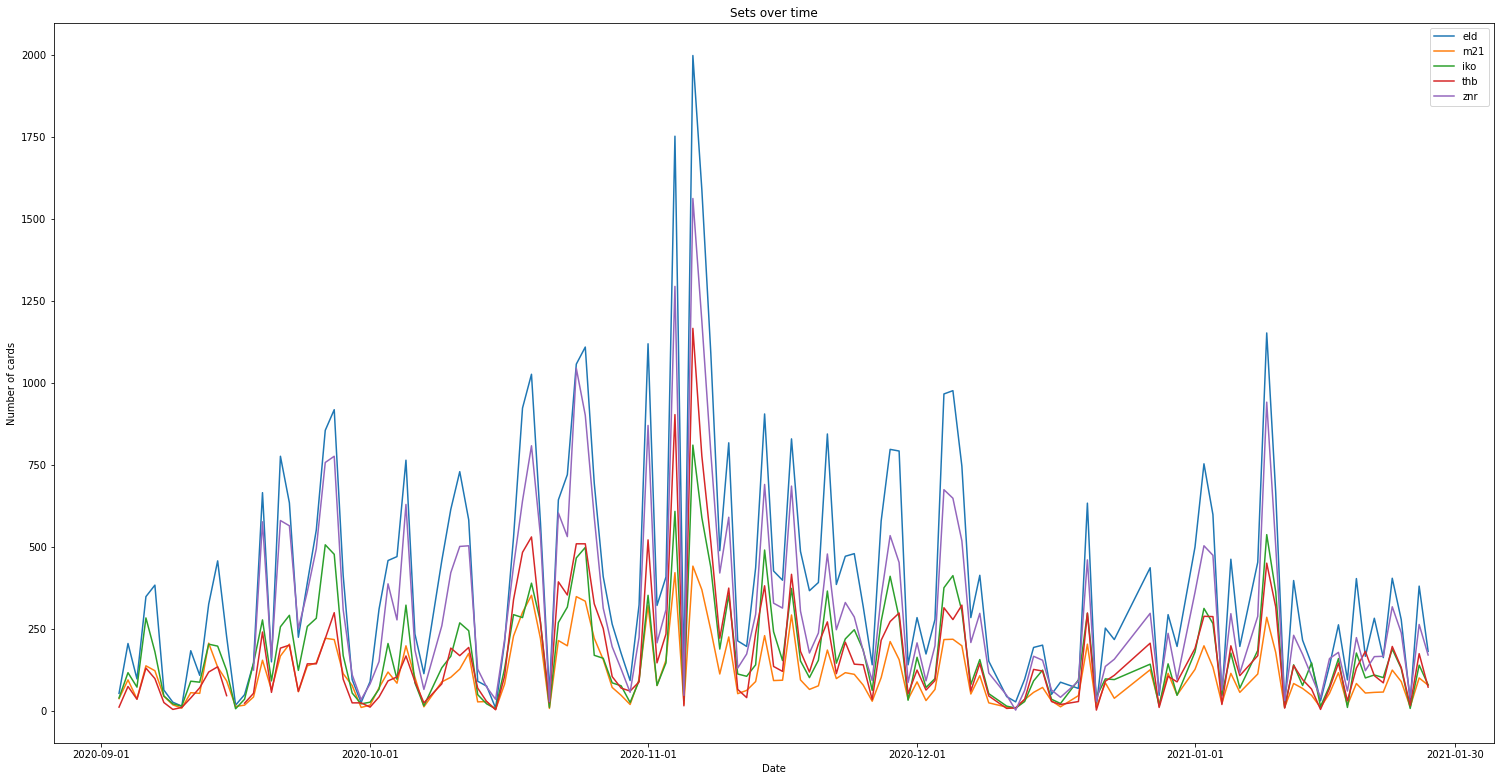

In [73]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
dates = list(map(pd.Timestamp.date, sets_by_date.date))

ax.plot(dates, sets_by_date.eld, label="eld")
ax.plot(dates, sets_by_date.m21, label="m21")
ax.plot(dates, sets_by_date.iko, label="iko")
ax.plot(dates, sets_by_date.thb, label="thb")
ax.plot(dates, sets_by_date.znr, label="znr")

ax.set_xticks(["2020-09-01", "2020-10-01", "2020-11-01", "2020-12-01", "2021-01-01", "2021-01-30"])
ax.legend()
fig.set_figwidth(20)
fig.set_figheight(10)

plt.title("Sets over time")
plt.xlabel("Date")
plt.ylabel("Number of cards")
plt.show()

In [74]:
sets_by_date.columns

Index(['date', 'eld', 'm21', 'iko', 'thb', 'znr'], dtype='object')

In [75]:
categories_by_dates = full_table.drop_duplicates(subset="deckId").groupby(["category", "date"]).deckId.count().reset_index()

In [76]:
categories_by_dates[categories_by_dates.category == "grixis"]

,category,date,deckId
330,grixis,2020-10-02,1
331,grixis,2020-10-04,1
332,grixis,2020-10-05,1
333,grixis,2020-10-06,1
334,grixis,2020-10-11,1
335,grixis,2020-10-18,1
336,grixis,2020-10-19,1
337,grixis,2020-11-01,1
338,grixis,2020-11-10,1
339,grixis,2020-11-17,1


In [77]:
event_table[(event_table.date >= "2020-10-31") & (event_table.date < "2020-11-10")].sort_values(by="date", ascending=False)

,eventId,name,link,date
274,275,Japan Championship 2020 Winter Daily Trial @ B...,https://www.mtgtop8.com/event?e=28076&f=ST,2020-11-09
275,276,Free Daily @ Owl Central Games,https://www.mtgtop8.com/event?e=28093&f=ST,2020-11-09
276,277,MTGO Standard Challenge,https://www.mtgtop8.com/event?e=28103&f=ST,2020-11-09
277,278,Monday Night Magic @ Plague League,https://www.mtgtop8.com/event?e=28106&f=ST,2020-11-09
278,279,SCG Tour Online - Satellite #8 @ Star City Games,https://www.mtgtop8.com/event?e=28056&f=ST,2020-11-08
279,280,Japan Championship 2020 Winter Weekly Challeng...,https://www.mtgtop8.com/event?e=28065&f=ST,2020-11-08
280,281,5k Kaldheim Championship Qualifier @ Star City...,https://www.mtgtop8.com/event?e=28071&f=ST,2020-11-08
281,282,NRG Series Online Trial #3 @ NRG Series,https://www.mtgtop8.com/event?e=28072&f=ST,2020-11-08
282,283,Mox Portland MtG Arena Tournament @ Mox Boardi...,https://www.mtgtop8.com/event?e=28074&f=ST,2020-11-08
283,284,MAJH Sunday Series @ Malchijah Harding,https://www.mtgtop8.com/event?e=28075&f=ST,2020-11-08


In [78]:
events_per_date = event_table.groupby("date").eventId.count().reset_index().rename(columns={"eventId": "event_count"})

In [79]:
events_per_date.sort_values(by="date",inplace=True)

In [80]:
events_per_date.sort_values(by="event_count", ascending=False)

,date,event_count
23,2020-09-26,11
64,2020-11-07,11
74,2020-11-17,10
58,2020-11-01,9
120,2021-01-09,8
...,...,...
97,2020-12-11,1
98,2020-12-12,1
106,2020-12-21,1
99,2020-12-13,1


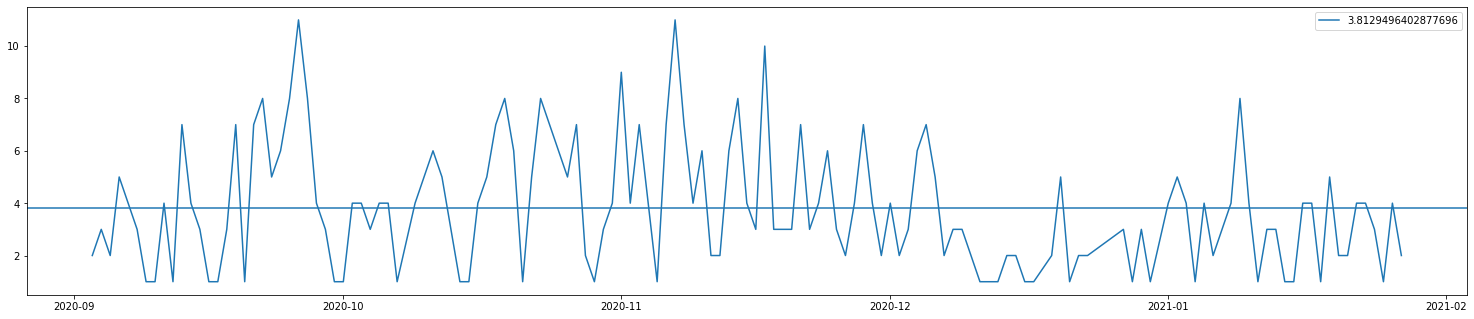

In [81]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

ax.plot(events_per_date.date, events_per_date.event_count)
ax.axhline(np.mean(events_per_date.event_count), label=str(np.mean(events_per_date.event_count)))
ax.legend()
fig.set_figwidth(20)
plt.show()

In [82]:
by_set = full_table[full_table["cardId"].str.contains("eld|m21|iko|thb|znr", regex=True)].copy()

In [83]:
by_set["set"] = full_table["cardId"].str.slice(-3)

In [84]:
by_set["month_name"] = by_set["date"].dt.month_name()

In [85]:
key = {
    "September": 1,
    "October": 2,
    "November": 3,
    "December": 4,
    "January": 5
}

grouped_set = (
    by_set.groupby(["month_name", "set"])["count"]
    .sum()
    .reset_index()
    .sort_values(by="month_name", key=lambda x: x.map(key))
)


In [86]:
grouped_set

,month_name,set,count
24,September,znr,5097
22,September,m21,2673
21,September,iko,4459
20,September,eld,8393
23,September,thb,2565
19,October,znr,10944
18,October,thb,5673
17,October,m21,4044
16,October,iko,5230
15,October,eld,13794


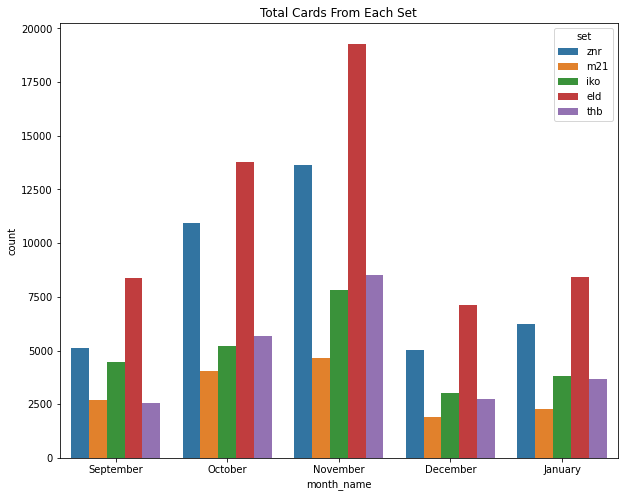

In [87]:
plt.close("all")
plt.figure(figsize=(10, 8))
sns.barplot(data=grouped_set, x="month_name", y="count", hue="set")
plt.title("Total Cards From Each Set")
plt.show()

In [88]:
archetypes_by_date["month_name"] = archetypes_by_date["date"].dt.month_name()

In [89]:
archetypes_by_date

,date,control,aggro,ramp,mill,adventure,rogue,month_name
0,2020-09-03,2,2,0,0,0,0,September
1,2020-09-04,7,5,0,0,1,0,September
2,2020-09-05,3,3,0,0,0,0,September
3,2020-09-06,18,7,0,0,1,0,September
4,2020-09-07,7,9,0,0,3,0,September
...,...,...,...,...,...,...,...,...
118,2021-01-23,4,13,1,2,0,0,January
119,2021-01-24,3,7,1,3,0,0,January
136,2021-01-25,0,2,0,0,0,0,January
120,2021-01-26,7,6,1,2,1,0,January


In [90]:
archetypes_melted = archetypes_by_date.melt(id_vars=["date", "month_name"], value_vars=["control", "aggro", "ramp", "mill", "adventure", "rogue"], value_name="count", var_name="archetype")

In [91]:
archetypes_melted[
    (archetypes_melted["month_name"]=="September") 
    & (archetypes_melted["archetype"] == "ramp")
]["count"].sum()

137

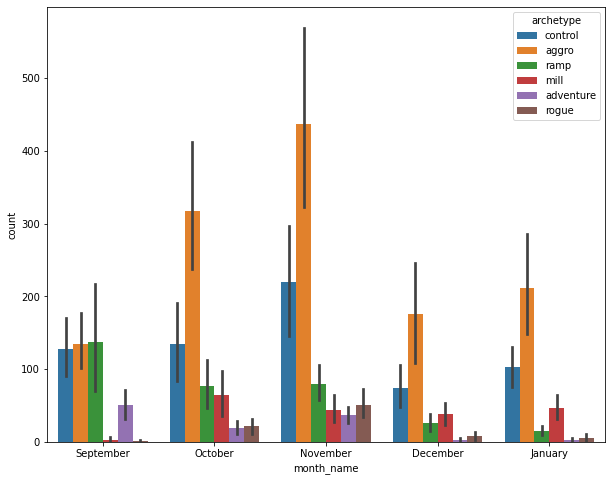

In [92]:
plt.close("all")
plt.figure(figsize=(10, 8))
sns.barplot(data=archetypes_melted, x="month_name", y="count", hue="archetype", estimator=sum)
plt.show()

In [93]:
x_values = archetypes_melted["month_name"].unique().tolist()
y_control = [
    archetypes_melted[
        (archetypes_melted["month_name"] == month_name)
        & (archetypes_melted["archetype"] == "control")
    ]["count"].sum()
    for month_name in x_values
]
y_aggro = [
    archetypes_melted[
        (archetypes_melted["month_name"] == month_name)
        & (archetypes_melted["archetype"] == "aggro")
    ]["count"].sum()
    for month_name in x_values
]
y_ramp = [
    archetypes_melted[
        (archetypes_melted["month_name"] == month_name)
        & (archetypes_melted["archetype"] == "ramp")
    ]["count"].sum()
    for month_name in x_values
]
y_adventure = [
    archetypes_melted[
        (archetypes_melted["month_name"] == month_name)
        & (archetypes_melted["archetype"] == "adventure")
    ]["count"].sum()
    for month_name in x_values
]
y_mill = [
    archetypes_melted[
        (archetypes_melted["month_name"] == month_name)
        & (archetypes_melted["archetype"] == "mill")
    ]["count"].sum()
    for month_name in x_values
]
y_rogue = [
    archetypes_melted[
        (archetypes_melted["month_name"] == month_name)
        & (archetypes_melted["archetype"] == "rogue")
    ]["count"].sum()
    for month_name in x_values
]

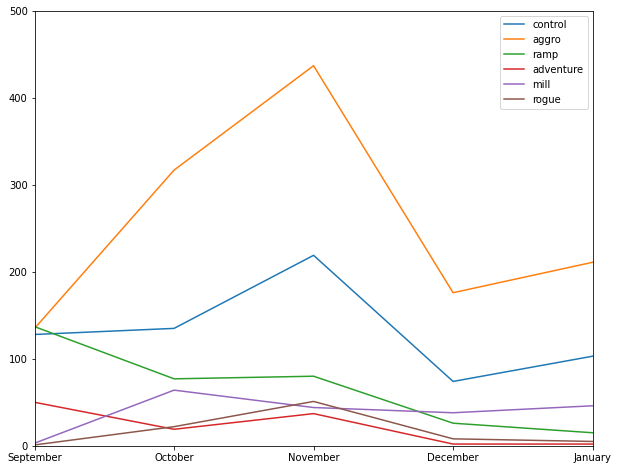

In [94]:
plt.close('all')

y_values = [y_control, y_aggro, y_ramp, y_adventure, y_mill]

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(x_values, y_control, label="control")
plt.plot(x_values, y_aggro, label="aggro")
plt.plot(x_values, y_ramp, label="ramp")
plt.plot(x_values, y_adventure, label="adventure")
plt.plot(x_values, y_mill, label="mill")
plt.plot(x_values, y_rogue, label="rogue")
plt.legend()
plt.axis(["September", "January", 0, 500])
plt.show()

In [95]:
x_values

['September', 'October', 'November', 'December', 'January']

In [96]:
y_control

[128, 135, 219, 74, 103]

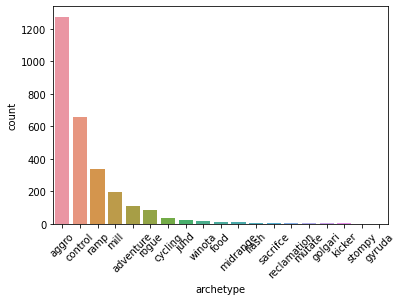

In [97]:
plt.clf()
sns.countplot(x=full_table.drop_duplicates(subset="deckId")["archetype"], order=full_table["archetype"].value_counts().index)
plt.xticks(rotation=45)
plt.show()

In [98]:
plt.clf()

<Figure size 432x288 with 0 Axes>

for col in full_table.columns:
    sns.countplot(x=full_table.drop_duplicates(subset="deckId")[col])
    plt.show()
    plt.clf()

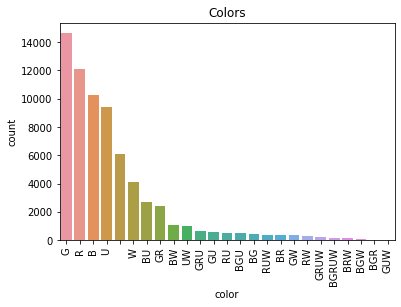

In [99]:

sns.countplot(
    x=full_table["color"],
    order=full_table["color"].value_counts().index
)
plt.title("Colors")
plt.xticks(rotation=90)
plt.show()

# Try adding a column for before/after a date, and use that as a bivariate variable to compare archetype frequencies, color dominance, etc.